# Portfolio Risk Management Script

This script is designed to perform portfolio risk management using mean-variance optimization and various risk measures. It fetches historical price data for a portfolio of assets, calculates optimal portfolio weights, and evaluates portfolio risk using methods such as Historical Value at Risk (VaR), Parametric VaR, Monte Carlo VaR, Parametric Conditional VaR (CVaR), and Lower Partial Standard Deviation (LPSD).

## Table of Contents
1. [Import Modules](#import-modules)
2. [Define Functions](#define-functions)
3. [Choose Input Data for Functions to Run Through](#choose-input-data-for-functions-to-run-through)
4. [Initialize Lists to Store Output Data](#initialize-lists-to-store-output-data)
5. [Loop Through Data and Store Outputs](#loop-through-data-and-store-outputs)

----

## 1. Import Modules

- `pandas as pd`: Used for data manipulation and analysis.
- `numpy as np`: Used for numerical operations.
- `yfinance as yf`: Used for fetching historical stock price data.
- `pypfopt.expected_returns`, `pypfopt.risk_models`, `pypfopt.EfficientFrontier`: Imported specific modules from the pypfopt library, which is used for portfolio optimization.
- `matplotlib.pyplot as plt`: Used for creating visualizations and plots.

In [129]:
import pandas as pd
import numpy as np
import yfinance as yf
from pypfopt import expected_returns, risk_models, EfficientFrontier
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

----

## 2. Define Functions

### 2.1 Fetch Stock Market Data

In [131]:
def fetch_historical_data(assets, start_date, end_date):
    """
    Fetch historical price data for the given assets within the specified date range.

    Parameters:
    - assets (list): List of asset tickers.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - pd.DataFrame: Historical adjusted close prices for the specified assets.
    """       
    if len(assets) == 1:
        # Wrap the Series in a DataFrame for consistency
        data = pd.DataFrame(yf.download(assets, start=start_date, end=end_date)['Adj Close'])
    else:
        data = yf.download(assets, start=start_date, end=end_date)['Adj Close']
    
    return data

### 2.2 Portfolio Metrics Calculation

The `calculate_portfolio_metrics` function computes various portfolio metrics using mean-variance optimization through the [PyPortfolioOpt library](https://github.com/robertmartin8/PyPortfolioOpt/blob/master/README.md). 

Each metric provides insights into different aspects of the portfolio's performance and risk profile. Here's an explanation of each metric:

#### 1. Historical Returns

**Definition:** Historical Returns represent the daily returns of the portfolio based on the provided historical price data.

**Calculation:** 
- Calculate daily asset returns using the percentage change in historical prices.
- Remove the first row containing NaN values.

----

#### 2. Expected Asset Returns

**Definition:** Expected Asset Returns are calculated using the Capital Asset Pricing Model (CAPM), predicting future returns based on the risk-free rate and asset beta.

**Calculation:** 
- Utilize the CAPM model to estimate expected returns for each asset in the portfolio.
- Frequency is set to 252 for daily data.

**Assumption:** The CAPM model assumes a linear relationship between an asset's expected return and its beta.

----

#### 3. Covariance Matrix

**Definition:** The Covariance Matrix quantifies the relationships between asset returns, essential for understanding diversification benefits.

**Calculation:** 
- Calculate the covariance matrix of daily asset returns.
- Default assumption is based on price data.

----

#### 4. Efficient Frontier

**Definition:** The Efficient Frontier represents the set of optimal portfolios that offer the highest expected return for a given level of risk.

**Calculation:** 
- Create an instance of the EfficientFrontier class using expected asset returns and the covariance matrix.
- Maximize the Sharpe ratio to find optimal portfolio weights.

----

#### 5. Expected Portfolio Return, Volatility, and Sharpe Ratio

**Definition:** These metrics quantify the expected return, historical volatility, and risk-adjusted performance of the portfolio.

**Calculation:** 
- Calculate optimal portfolio weights to maximize the Sharpe ratio.
- Perform mean-variance optimization to determine expected portfolio return, volatility, and Sharpe ratio.

**Note:** Volatility is calculated as the standard deviation of portfolio returns multiplied by the square root of 252.

----

#### 6. Asset Weights and Sum of Weights

**Definition:** Asset Weights represent the allocation of capital to each asset in the portfolio. The Sum of Weights should equal 1, representing full capital allocation.

**Calculation:** 
- Extract the optimal portfolio weights and assign them as a list.
- Calculate the sum of weights to ensure full capital allocation.

**Adjustment:** You can modify the capital allocation by adjusting the weights, potentially leaving some capital in the risk-free asset.

----

#### 7. Historical Portfolio Returns

**Definition:** Historical Portfolio Returns represent the daily returns of the portfolio based on the optimal weights.

**Calculation:** 
- Calculate the historical portfolio returns by applying optimal weights to asset returns.

----

#### 8. Annual Portfolio Returns and Historic Sharpe Ratio

**Definition:** Annual Portfolio Returns represent the average annualized return of the portfolio. The Historic Sharpe Ratio quantifies the risk-adjusted performance.

**Calculation:** 
- Annualize the historical portfolio returns by multiplying the mean return by 252.
- Calculate the Historic Sharpe Ratio by dividing the annualized returns by volatility.

----

The `calculate_portfolio_metrics` function provides a comprehensive set of metrics for evaluating portfolio performance and risk. Adjustments can be made to optimize the portfolio based on specific goals and risk preferences.



In [133]:
def calculate_portfolio_metrics(data, risk_free_rate):
    """
    Calculate portfolio metrics using mean-variance optimization.

    Parameters:
    - data (pd.DataFrame): Historical price data for the assets.
    - risk_free_rate (float): Risk-free rate used in the calculations.

    Returns:
    - dict: Dictionary containing various portfolio metrics.
    """
    # Calculate daily asset returns and remove first NaN row.
    returns = data.pct_change().dropna()
    
    # Calculate returns predicted by CAPM.
    predicted_asset_returns = expected_returns.capm_return(data, risk_free_rate=risk_free_rate, frequency=252)
    # The optimization is mathematically sound but dependant on input parameters.
    # 'predicted_asset_returns' can be improved using Black-Litterman Allocation.
    
    # Calculate the covariance matrix of returns.
    # Default assumes price data.
    cov_matrix = risk_models.sample_cov(returns, returns_data=True)
    
    # Create an instance of the EfficientFrontier class.
    ef = EfficientFrontier(predicted_asset_returns, cov_matrix)
    
    # Calculate optimal portfolio weights to maximize Sharpe ratio.    
    weights = ef.max_sharpe()
    # Can add in constraints and optimise according to IPS.
    # Review pypfopt library for additional optimization specifications.
    
    # Mean-Variance Optimization (highest return for lowest volatility).
    # Calculates expected return, (historical) volatility and (Expected) Sharpe ratio.
    portfolio_expected_return, volatility, sharpe_ratio = ef.portfolio_performance()
    # Where Volatility = returns.dot(optimal_weights).std() * np.sqrt(252) * 100

    # Assign 'weight` values dictionary to the `optimal_weights` as list.
    optimal_weights = list(weights.values())
    # Max Capital Allocation: Sum of weights = 1.
    weights_sum = sum(optimal_weights)
    # Can adjust this so some of the capital remains in the Rf asset
    
    # Calculate historical portfolio daily returns
    historic_portfolio_returns = returns.dot(optimal_weights)
    
    # Annualized returns
    annual_portfolio_returns = historic_portfolio_returns.mean() * 252
    
    #Calculate Historic Sharpe Ratio.
    historic_sharpe_ratio = annual_portfolio_returns/volatility

    
    return {
        "Historical Returns": returns,
        "Expected Asset Returns": predicted_asset_returns,
        "Covariance Matrix": cov_matrix,
        "Efficient Frontier": ef,
        "Expected Portfolio Return": portfolio_expected_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Historic Sharpe Ratio": historic_sharpe_ratio,
        "Asset Weights": optimal_weights,
        "Sum of Weights": weights_sum,
        "Historical Portfolio Returns": historic_portfolio_returns,
        "Annual Portfolio Returns": annual_portfolio_returns
    }

#### Example 1: Building a Portfolio Optimized for Risk-Adjusted Returns

In [135]:
assets = ["AAPL", "AMZN", "NVDA", "GOOGL", "TSLA", "UNH", "LLY", "XOM", "JPM", "V", "JNJ"]
data = fetch_historical_data(assets, start_date='2021-01-01', end_date='2023-12-31')
portfolio_metrics = calculate_portfolio_metrics(data, risk_free_rate=0.03)

# Extract relevant metrics from the dictionary
subset_metrics = {
    "Expected Portfolio Return": portfolio_metrics["Expected Portfolio Return"],
    "Volatility": portfolio_metrics["Volatility"],
    "Sharpe Ratio": portfolio_metrics["Sharpe Ratio"],
    "Historic Sharpe Ratio": portfolio_metrics["Historic Sharpe Ratio"],
    "Asset Weights": portfolio_metrics["Asset Weights"],
    "Sum of Weights": portfolio_metrics["Sum of Weights"],
    "Annual Portfolio Returns": portfolio_metrics["Annual Portfolio Returns"]
}

# Print the subset of metrics with line breaks
for metric_name, metric_value in subset_metrics.items():
    print(f"{metric_name}: {metric_value}\n")

[*********************100%%**********************]  11 of 11 completed

Expected Portfolio Return: 0.22307542075782655

Volatility: 0.19273485198665194

Sharpe Ratio: 1.053651784638778

Historic Sharpe Ratio: 1.1408768357557226

Asset Weights: [0.0833258949364403, 0.0848358437549641, 0.0854671411050927, 0.1328145129209137, 0.0888423132672468, 0.0848058117804685, 0.0798939758084096, 0.083025032608728, 0.0946616288669214, 0.0900381942207136, 0.0922896507301015]

Sum of Weights: 1.0000000000000002

Annual Portfolio Returns: 0.219886728074379



### 2.3 Risk Measures Calculation

The `calculate_risk_measures` function computes various risk measures for a portfolio. Each risk measure provides insights into different aspects of the portfolio's risk profile. Here's an explanation of each risk measure:

#### 1. Historical Value at Risk (VaR)

**Definition:** Historical VaR is a measure of the potential loss of a portfolio based on historical return data.

**Calculation:** 
- Simulate portfolio returns using historical data.
- Sort the simulated returns in ascending order.
- Identify the potential loss at a specified confidence level by selecting the corresponding percentile.

**Assumption:** Historical VaR assumes that future returns will follow a similar distribution as historical returns.

**Wikipedia Link:** [Value at Risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk)

----

#### 2. Parametric Value at Risk (VaR)

**Definition:** Parametric VaR estimates potential losses based on the expected return and volatility of the portfolio.

**Calculation:** 
- Use the expected return and volatility of the portfolio.
- Calculate the number of standard deviations from the mean (Z-score) based on the confidence level.
- Multiply the Z-score by the portfolio volatility and the square root of the time horizon to get the potential loss.

**Assumption:** Parametric VaR assumes that returns follow a normal distribution.

**Wikipedia Link:** [Value at Risk (VaR)](https://en.wikipedia.org/wiki/Value_at_risk)

----

#### 3. Monte Carlo Value at Risk

**Definition:** Monte Carlo VaR simulates various scenarios of portfolio returns to estimate potential losses.

**Calculation:** 
- Generate random returns for each asset using a normal distribution.
- Calculate the portfolio return for multiple simulations.
- Identify the potential loss at a specified confidence level.

**Assumption:** Monte Carlo VaR assumes that future returns can be simulated based on historical mean and volatility.

**Wikipedia Link:** [Monte Carlo method in finance](https://en.wikipedia.org/wiki/Monte_Carlo_method_in_finance)

----

#### 4. Parametric Conditional Value at Risk (CVaR)

**Definition:** Parametric CVaR, or Expected Shortfall, is the weighted average of extreme losses beyond the VaR cutoff point.

**Calculation:** 
- Similar to Parametric VaR calculation.
- Additionally, calculate the expected shortfall by averaging losses beyond the VaR.

**Assumption:** Parametric CVaR assumes that returns follow a normal distribution.

**Wikipedia Link:** [Expected shortfall](https://en.wikipedia.org/wiki/Expected_shortfall)

----

#### 5. Lower Partial Standard Deviation (LPSD)

**Definition:** LPSD measures the standard deviation of negative returns, providing insights into downside risk.

**Calculation:** 
- Consider only negative returns below a specified threshold.
- Calculate the standard deviation of these negative returns.

**Assumption:** LPSD does not assume normality but focuses on the downside risk.

**Wikipedia Link:** [Downside risk](https://en.wikipedia.org/wiki/Downside_risk)

In [137]:
def calculate_risk_measures(returns, predicted_asset_returns, cov_matrix, ef, optimal_weights,
                            initial_portfolio_value, portfolio_expected_return, volatility,
                            historic_portfolio_returns,
                            n_simulations=10000, time_horizon=1, confidence_level=0.05):
    """
    Calculate various risk measures for a portfolio.

    Parameters:
    - returns (pd.Series): Historical returns of the portfolio.
    - predicted_asset_returns (pd.Series): Expected returns predicted by a model.
    - cov_matrix (pd.DataFrame): Covariance matrix of asset returns.
    - ef (EfficientFrontier): Instance of the EfficientFrontier class.
    - optimal_weights (list): List of optimal portfolio weights.
    - initial_portfolio_value (float): Initial value of the portfolio.
    - portfolio_expected_return (float): Expected return of the portfolio.
    - volatility (float): Portfolio volatility.
    - historic_portfolio_returns (pd.Series): Historical portfolio returns.
    - n_simulations (int): Number of simulations for Monte Carlo methods. Default is 10000.
    - time_horizon (int): Time horizon for risk measures. Default is 1.
    - confidence_level (float): Confidence level for risk measures. Default is 0.05.

    Returns:
    - dict: Dictionary containing various risk measures, including Historical VaR, Parametric VaR,
            Portfolio VaR, Monte Carlo VaR, Parametric CVaR, and Lower Partial Standard Deviation (LPSD).
    """    
    # 1) Historical VaR: Historical simulation
    
    # Number of Monte Carlo simulations
    n_simulations = 10000

    # Initialize an empty list to store portfolio returns
    portfolio_returns = []

    for _ in range(n_simulations):
        # Generate random returns for each asset using normal distribution
        random_returns = np.random.normal(portfolio_expected_return, volatility, len(assets))

        # Calculate the portfolio return for each simulation
        portfolio_return = np.dot(random_returns, optimal_weights)

        # Append the portfolio return to the list
        portfolio_returns.append(portfolio_return)

    # Calculate the VaR based on the simulated portfolio returns
    sorted_portfolio_returns = sorted(portfolio_returns)
    var_index = int(n_simulations * confidence_level)
    historical_portfolio_var = sorted_portfolio_returns[var_index]

    
    # 2) Parametric VaR:
    
    # Forward-looking using expected return and volatility.
    
    # Call `portfolio_performance()` method to calculate variables. 
    portfolio_expected_return, volatility, _ = ef.portfolio_performance()
    
    # Calculate number of standard deviations from mean. Assumes Normality.
    z_score = norm.ppf(1 - confidence_level)
    parametric_var = volatility * z_score * np.sqrt(time_horizon) * 100
    
    # Calculate value below which actual portfolio return is expected to fall
    # with a certain confidence level based on the distribution of 
    # expected portfolio returns.
    portfolio_var = -np.percentile(portfolio_metrics["Historical Portfolio Returns"], confidence_level * 100) * 100

    
    # 3) Monte Carlo simulation: 
    
    # Uses Forward-looking expected return, Backward-looking volatility.
    # Takes the asset std dev from the cov matrix diagonals. Assumes Normality.
    
    portfolio_values = []

    for _ in range(n_simulations):
        # Generate random returns for each asset using normal distribution
        random_returns = np.random.normal(portfolio_expected_return, volatility, len(assets))

        # Calculate the portfolio return for the time horizon
        portfolio_return = np.dot(random_returns, optimal_weights)

        # Calculate the portfolio value at the end of the time horizon
        portfolio_value = initial_portfolio_value * (1 + portfolio_return)

        portfolio_values.append(portfolio_value)
    
    # Calculate the VaR
    sorted_portfolio_values = np.sort(portfolio_values)
    var_index = int(n_simulations * confidence_level)
    monte_carlo_var = -(initial_portfolio_value - sorted_portfolio_values[var_index]) / initial_portfolio_value
    

    # 4) Parametric CVaR (Expected Shortfall): 
    parametric_cvar = (volatility * z_score / np.sqrt(2 * np.pi)) * np.exp(-(z_score ** 2) / 2) * 100

    # 5) LPSD (Lower Partial Standard Deviation)
    
    # Only consider negative returns.
    threshold = 0
 
    lpsd = np.std(historic_portfolio_returns[historic_portfolio_returns<threshold]) * 100

    return {
    "Historical VaR": historical_portfolio_var,
    "Parametric VaR": parametric_var,
    "Portfolio VaR": portfolio_var,
    "Monte Carlo VaR": monte_carlo_var,
    "Parametric CVaR": parametric_cvar,
    "LPSD": lpsd
    }

----

### 2.4 Evaluating Portfolio Performance Against a Benchmark

In [180]:
def calculate_benchmark_return(benchmark, start_date, end_date):
    """
    Calculate benchmark return, annual return, volatility, and Sharpe ratio.

    Parameters:
    - benchmark (str): Symbol for the benchmark (e.g., "^GSPC").
    - start_date (str): Start date for fetching historical data.
    - end_date (str): End date for fetching historical data.

    Returns:
    - dict: Dictionary containing benchmark metrics.
    """
    # Fetch historical data for the benchmark
    benchmark_data = fetch_historical_data(benchmark, start_date, end_date)

    # Fetch historical data for the benchmark
    benchmark_returns = fetch_historical_data(benchmark, start_date, end_date).pct_change().dropna()
    
    # Calculate annual return
    first_return = benchmark_data.iloc[0]
    last_return = benchmark_data.iloc[-1]
    annual_return = ((last_return) / (first_return) - 1) * 100
    
    # Calculate annualized daily volatility
    volatility = benchmark_returns.std() * np.sqrt(252) * 100
    
    # Calculate Sharpe ratio
    sharpe_ratio = annual_return / volatility
    
    return {
        "Benchmark Annual Return": annual_return,
        "Benchmark Volatility": volatility,
        "Benchmark Sharpe Ratio": sharpe_ratio
    }

#### Example 2: Calculating the Benchmark Performance

- The total return version of an index, such as the S&P 500 Total Return (^SP500TR), assumes the reinvestment of dividends back into the index, contributing to the overall return.
- Provides a more accurate representation of the total performance of the index

> **Note:** The metrics, including historical annual returns, may vary based on the data source and the calculation method used. It's essential to consider these differences and choose a source or methodology that aligns with the specific scenario or analysis.

In [66]:
benchmark_metrics = calculate_benchmark_return(benchmark="^GSPC", start_date='2008-01-01', end_date='2008-12-31')
print(benchmark_metrics)
benchmark_metrics = calculate_benchmark_return(benchmark="^SP500TR", start_date='2008-01-01', end_date='2008-12-31')
print(benchmark_metrics)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

{'Benchmark Annual Return': -38.456010834123774, 'Benchmark Volatility': 0.4108617414615195, 'Benchmark Sharpe Ratio': -93.59842242144}
{'Benchmark Annual Return': -36.982326997739555, 'Benchmark Volatility': 0.4107862059468626, 'Benchmark Sharpe Ratio': -90.02816175994823}


- [S&P 500 Historical Annual Returns](https://www.macrotrends.net/2526/sp-500-historical-annual-returns) quotes the 2008 return as -38.49%, which is in close agreement with `calculate_benchmark_return(benchmark="^GSPC")` = -38.456%

- [McKinsey & Company](https://www.mckinsey.com/capabilities/strategy-and-corporate-finance/our-insights/the-strategy-and-corporate-finance-blog/markets-will-be-markets-an-analysis-of-long-term-returns-from-the-s-and-p-500) quotes a "37 percent fall in 2008", in close agreement to `calculate_benchmark_return(benchmark="^SP500TR")` = -36.982%, whilst [Backtest by Curvo](https://curvo.eu/backtest/en/market-index/sp-500?currency=eur) says it was only -33.36%. 

## 3. Choose Input Data for Functions to Run Through

In [192]:
def configure():
    """
    Choose input data for functions to run through.

    Returns:
    - tuple: Tuple containing input data (assets, sp500, start_year, end_year).
    """
    assets = ["AAPL", "AMZN", "NVDA", "GOOGL", "TSLA", "UNH", "LLY", "XOM", "JPM", "V", "JNJ"]
    benchmark = "^GSPC"
    start_year = 2010
    end_year = 2020
    risk_free_rate = 0.03
    initial_portfolio_value = 100
    n_simulations = 250
    confidence_level = 0.05

    return assets, benchmark, start_year, end_year, risk_free_rate, initial_portfolio_value, n_simulations, confidence_level

----

## 4. Initialize Lists to Store Output Data

In [196]:
years = []

portfolio_annual_returns = []
historical_portfolio_returns = []
volatilities = []
sharpe_ratios = []

benchmark_annual_returns = []
benchmark_volatilities = []
benchmark_sharpe_ratios = []

historical_portfolio_var_list = []
parametric_var_list = []
portfolio_var_list = []
monte_carlo_var_list = []
parametric_cvar_list = []
lpsd_list = []

----

## 5. Loop Through Data and Store Outputs

[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed
[*********************10

Average Portfolio Metrics:
Return: 24.78%
Volatility: 15.01%
Sharpe Ratio: 1.80
Average Benchmark Metrics:
Return: 10.96%
Volatility: 14.09%
Sharpe Ratio: 1.04


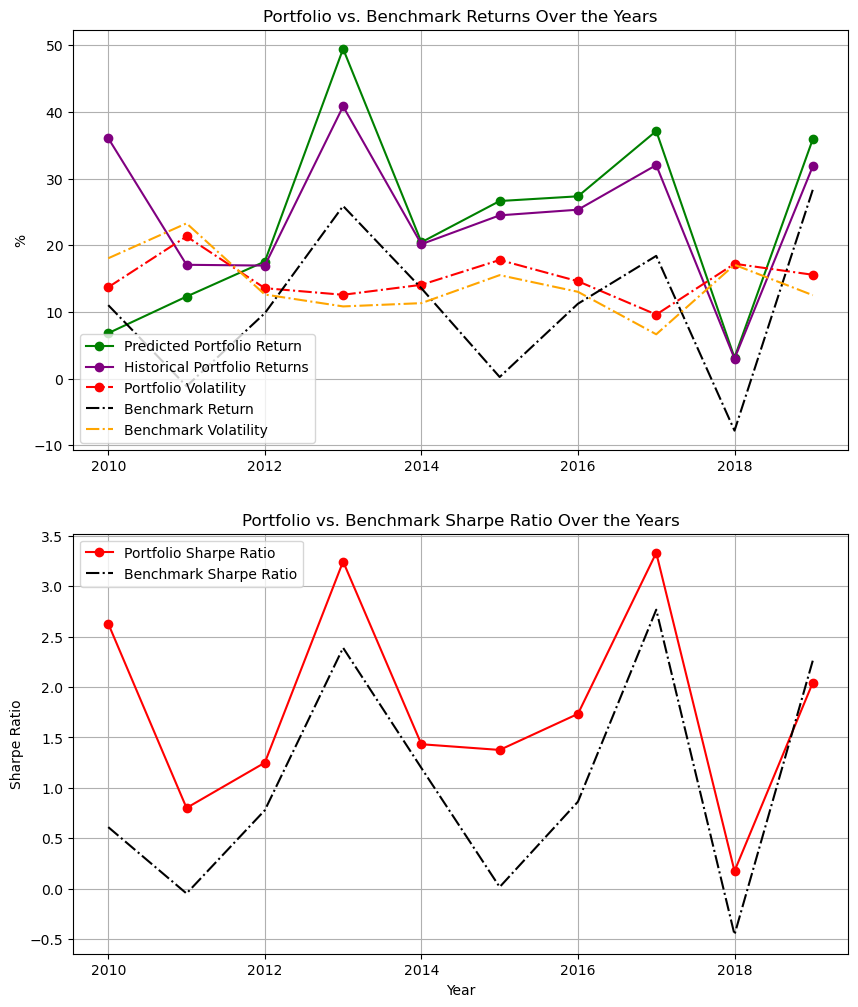

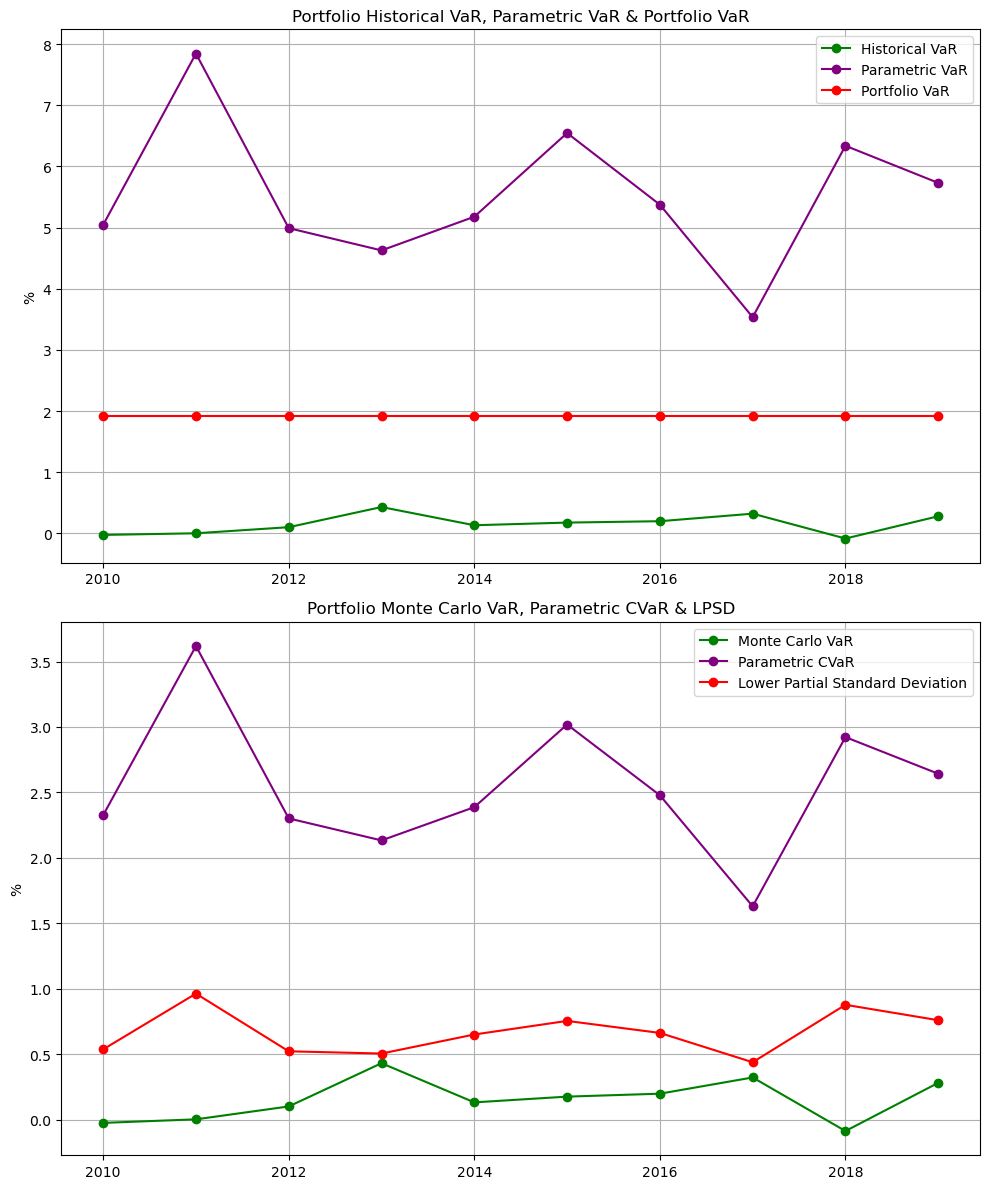

In [200]:
def main():
    # Get configuration settings
    assets, benchmark, start_year, end_year, risk_free_rate, initial_portfolio_value, n_simulations, confidence_level = configure()

    # Initialize lists to store metrics for each year
    benchmark_annual_returns = []
    benchmark_volatilities = []
    benchmark_sharpe_ratios = []

    for year in range(start_year, end_year):
        # Define start_date and end_date based on the current year:
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        # Choose this rolling window based on your portfolio rebalancing time-frame.

        # Fetch historical data for the current year:
        data = fetch_historical_data(assets, start_date, end_date)

        # Calculate Portfolio Metrics for the current year:
        portfolio_metrics = calculate_portfolio_metrics(data, risk_free_rate)

        # Calculate Benchmark Metrics for the current year:
        benchmark_metrics = calculate_benchmark_return(benchmark=benchmark, start_date=start_date, end_date=end_date)

        # Append the data to the lists:
        years.append(year)
        portfolio_annual_returns.append(portfolio_metrics['Expected Portfolio Return'] * 100)  # Convert to percentage
        historical_portfolio_returns.append(portfolio_metrics["Annual Portfolio Returns"] * 100)
        volatilities.append(portfolio_metrics["Volatility"] * 100)
        sharpe_ratios.append(portfolio_metrics["Historic Sharpe Ratio"])

        # Append Benchmark Metrics to the lists:
        benchmark_annual_returns.append(benchmark_metrics['Benchmark Annual Return'])
        benchmark_volatilities.append(benchmark_metrics['Benchmark Volatility'])
        benchmark_sharpe_ratios.append(benchmark_metrics['Benchmark Sharpe Ratio'])

        # Measure VaR of portfolio:
        risk_measures = calculate_risk_measures(portfolio_metrics["Historical Returns"],
                                                portfolio_metrics["Expected Asset Returns"],
                                                portfolio_metrics["Covariance Matrix"],
                                                portfolio_metrics["Efficient Frontier"],
                                                portfolio_metrics["Asset Weights"],
                                                initial_portfolio_value,
                                                portfolio_metrics["Expected Portfolio Return"],
                                                portfolio_metrics["Volatility"],
                                                portfolio_metrics["Historical Portfolio Returns"],
                                                n_simulations,
                                                confidence_level)

        # Append the data to the lists:
        historical_portfolio_var_list.append(risk_measures["Historical VaR"])
        parametric_var_list.append(risk_measures["Parametric VaR"])
        portfolio_var_list.append(risk_measures["Portfolio VaR"])
        monte_carlo_var_list.append(risk_measures["Monte Carlo VaR"])
        parametric_cvar_list.append(risk_measures["Parametric CVaR"])
        lpsd_list.append(risk_measures["LPSD"])

    # CALCULATE AGGREGATE DATA:

    average_volatility = sum(volatilities) / len(volatilities)
    average_sharpe_ratio = sum(sharpe_ratios) / len(sharpe_ratios)
    average_return = sum(historical_portfolio_returns) / len(historical_portfolio_returns)
    # Use the Geometric return if you want the compounded Rate of Return.

    # Extract Benchmark Metrics for aggregate data:
    average_benchmark_return = sum(benchmark_annual_returns) / len(benchmark_annual_returns)
    average_benchmark_volatility = sum(benchmark_volatilities) / len(benchmark_volatilities)
    average_benchmark_sharpe_ratio = sum(benchmark_sharpe_ratios) / len(benchmark_sharpe_ratios)

    # DISPLAY RESULTS

    print("Average Portfolio Metrics:\nReturn: {:.2f}%\nVolatility: {:.2f}%\nSharpe Ratio: {:.2f}".format(
        average_return, average_volatility, average_sharpe_ratio))
    print("Average Benchmark Metrics:\nReturn: {:.2f}%\nVolatility: {:.2f}%\nSharpe Ratio: {:.2f}".format(
        average_benchmark_return, average_benchmark_volatility, average_benchmark_sharpe_ratio))

    # Plot Historical + Predicted Portfolio Return & Volatility vs. Benchmark:

    # Create subplots:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    ax1.plot(years, portfolio_annual_returns, color='green', marker='o', linestyle='-', label="Predicted Portfolio Return")
    ax1.plot(years, historical_portfolio_returns, color='purple', marker='o', linestyle='-', label="Historical Portfolio Returns")
    ax1.plot(years, volatilities, color='red', marker='o', linestyle='-.', label="Portfolio Volatility")
    ax1.plot(years, benchmark_annual_returns, color='black', linestyle='-.', label='Benchmark Return')
    ax1.plot(years, benchmark_volatilities, color='orange', linestyle='-.', label='Benchmark Volatility')

    ax1.set_title('Portfolio vs. Benchmark Returns Over the Years')
    ax1.set_ylabel('%')
    ax1.grid()
    ax1.legend()

    # Plot Portfolio Sharpe Ratio versus Benchmark:
    ax2.plot(years, sharpe_ratios, marker='o', color='red', label="Portfolio Sharpe Ratio")
    ax2.plot(years, benchmark_sharpe_ratios, color='black', linestyle='-.', label='Benchmark Sharpe Ratio')

    ax2.set_title('Portfolio vs. Benchmark Sharpe Ratio Over the Years')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.grid()
    ax2.legend()

    plt.show()

    # Plot Portfolio VaR Measures:

    # Create subplots:
    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot Historical VaR, Parametric VaR & Portfolio VaR:
    ax3.plot(years, historical_portfolio_var_list, color='green', marker='o', linestyle='-', label="Historical VaR")
    ax3.plot(years, parametric_var_list, color='purple', marker='o', linestyle='-', label="Parametric VaR")
    ax3.plot(years, portfolio_var_list, color='red', marker='o', linestyle='-', label="Portfolio VaR")

    ax3.set_title('Portfolio Historical VaR, Parametric VaR & Portfolio VaR')
    ax3.set_ylabel('%')
    ax3.grid()
    ax3.legend()

    # Plot Monte Carlo VaR, Parametric CVaR & LPSD:
    ax4.plot(years, monte_carlo_var_list, color='green', marker='o', linestyle='-', label="Monte Carlo VaR")
    ax4.plot(years, parametric_cvar_list, color='purple', marker='o', linestyle='-', label="Parametric CVaR")
    ax4.plot(years, lpsd_list, color='red', marker='o', linestyle='-', label="Lower Partial Standard Deviation")

    ax4.set_title('Portfolio Monte Carlo VaR, Parametric CVaR & LPSD')
    ax4.set_ylabel('%')
    ax4.grid()
    ax4.legend()

    plt.tight_layout()

    plt.show()
    
if __name__ == "__main__":
    main()

----